# Autocorrélation spatiale
Reproduction avec R l'essentiel d'une analyse menée avec Geoda.

-/-/- - Author: Abdoulaye DIALLO  
-/-/- - École: ENSAI  
-/-/- - Cours: Spatial Data  

#### Sources et Références
#### [Spatial Econometrics housing-prices](https://rpubs.com/eosowska/housing-prices)  
#### [Contiguity-Based Spatial Weights](https://geodacenter.github.io/workbook/4a_contig_weights/lab4a.html)

#### [Spatial autocorrelation analysis in R](https://rstudio-pubs-static.s3.amazonaws.com/576046_e2f9d38936714213b10bc7717b000ac5.html)  Carlos Mendez

----------------------------

La première loi de la géographie de **Waldo Tober**: `tout est lié à tout le reste, mais les choses proches sont plus liées que les choses lointaine`.

----------------------------

In [1]:
options(warn=-1)
library(spgwr)
library(tmap)
library(ggplot2) # for the mapping tools library(sf)
library(tibble)
library(GISTools)
library(rgdal)
library(grid)
library(spdep) # spatial autocorr
library(rgeos)
library(raster)
library(foreign)

Loading required package: sp

Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

NOTE: This package does not constitute approval of GWR
as a method of spatial analysis; see example(gwr)

Loading required package: maptools

Checking rgeos availability: TRUE

Loading required package: RColorBrewer

Loading required package: MASS

Loading required package: rgeos

rgeos version: 0.5-5, (SVN revision 640)
 GEOS runtime version: 3.8.1-CAPI-1.13.3 
 Linking to sp version: 1.4-2 
 Polygon checking: TRUE 


rgdal: version: 1.5-18, (SVN revision 1082)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.1.4, released 2020/10/20
Path to GDAL shared files: /Library/Frameworks/R.framework/Versions/4.0/Resources/library/rgdal/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 6.3.1, Feb

## Les donnnées

#### chargement des données non spatial

In [106]:
# Chargeons les données non spatial à fusionée avec les données spati
medianhousing = read.dbf("medianhousing/medianhousing.dbf")

In [76]:
# data type de la base
summary(medianhousing)

    POLY_ID                        GEO_ID    STATE    COUNTY        TRACT    
 Min.   :  1.00   1400000US25017300100:  1   25:310   017:310   300100 :  1  
 1st Qu.: 78.25   1400000US25017301101:  1                      301101 :  1  
 Median :155.50   1400000US25017301102:  1                      301102 :  1  
 Mean   :155.50   1400000US25017310100:  1                      310100 :  1  
 3rd Qu.:232.75   1400000US25017310200:  1                      310200 :  1  
 Max.   :310.00   1400000US25017310300:  1                      310300 :  1  
                  (Other)             :304                      (Other):304  
      NAME        LSAD       SHAPE_AREA          SHAPE_LEN    
 3001   :  1   Tract:310   Min.   :   292701   Min.   : 2269  
 3011.01:  1               1st Qu.:  2007350   1st Qu.: 6485  
 3011.02:  1               Median :  5347818   Median :11710  
 3101   :  1               Mean   : 12742308   Mean   :14364  
 3102   :  1               3rd Qu.: 14598492   3rd Qu.:19128 

In [73]:
# data head
head(medianhousing, 3)

,POLY_ID,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,SHAPE_AREA,SHAPE_LEN,Id,Id2,Geography,Median_val,Median_v_1
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>
1,1,1400000US25017300100,25,017,300100,3001,Tract,115348430,48105.94,1400000US25017300100,25017300100,"Census Tract 3001, Middlesex County, Massachusetts",286700,15865
2,2,1400000US25017301101,25,017,301101,3011.01,Tract,82527315,41749.43,1400000US25017301101,25017301100,"Census Tract 3011.01, Middlesex County, Massachusetts",290800,14919
3,3,1400000US25017301102,25,017,301102,3011.02,Tract,75895484,37792.83,1400000US25017301102,25017301100,"Census Tract 3011.02, Middlesex County, Massachusetts",292500,9212


#### chargement des données spatial

In [77]:
spatial.areas = readOGR("medianhousing/", "medianhousing")

OGR data source with driver: ESRI Shapefile 
Source: "/Users/abdoulayediallo/Documents/Documents – MacPro/ENSAI/Cours/econometrie_spatial/tp/spatial-econometrics/medianhousing", layer: "medianhousing"
with 310 features
It has 14 fields
Integer64 fields read as strings:  POLY_ID 


In [93]:
# Merge par la clé POLY_ID (table droite) et (table gauche)
# area_medianhousing = merge(spatial.areas, medianhousing, by.x="POLY_ID", by.y="POLY_ID")

# conversion en sf
spatial.areas_sf = st_as_sf(spatial.areas)

### Analyse stastiques de la variables Median Val.
#### a. vue par une carte

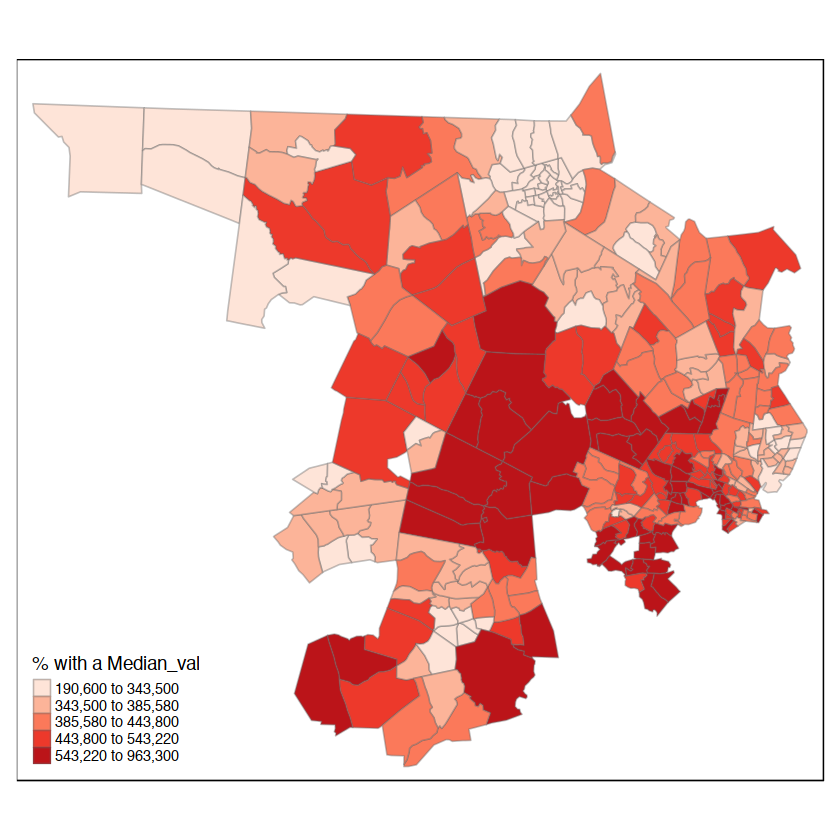

In [94]:
# 
tm_shape(spatial.areas_sf) + tm_fill("Median_val", palette = "Reds", style = "quantile", title =
"% with a Median_val") + tm_borders(alpha=.4)

#### b. vue par histogramme

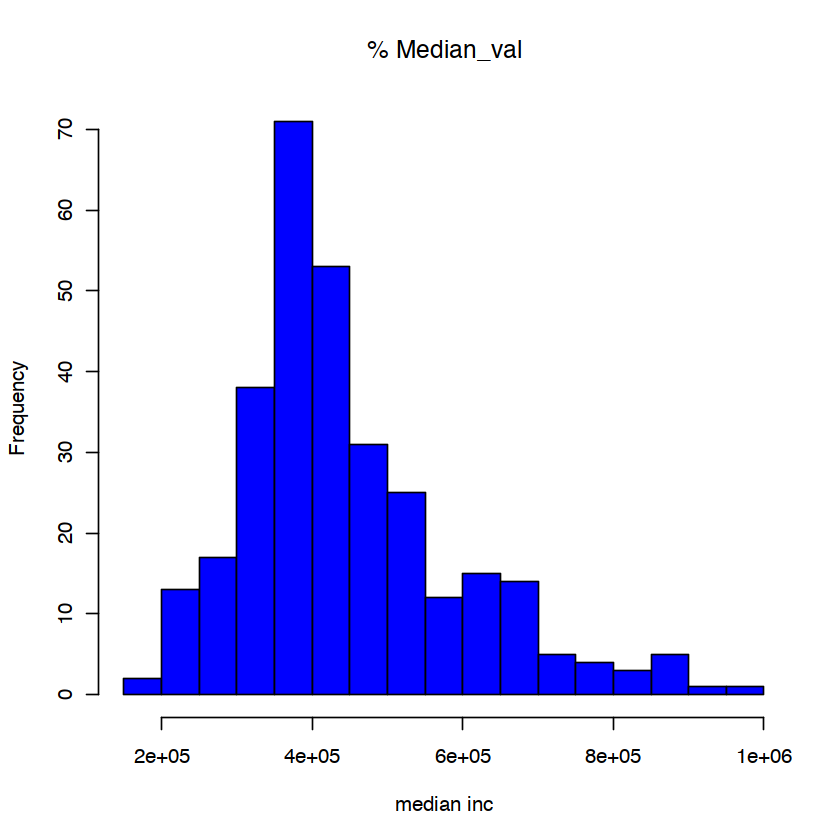

In [98]:
hist(spatial.areas$Median_val, breaks = 20, col = "blue", 
     main = "% Median_val", xlab = "median inc")

## 2. Autocorrélation spatiale

#### a. Création un histogramme des voisins de poids.

In [95]:
# Calculate neighbours
neighbours <- poly2nb(spatial.areas)
neighbours

Neighbour list object:
Number of regions: 310 
Number of nonzero links: 1710 
Percentage nonzero weights: 1.779396 
Average number of links: 5.516129 

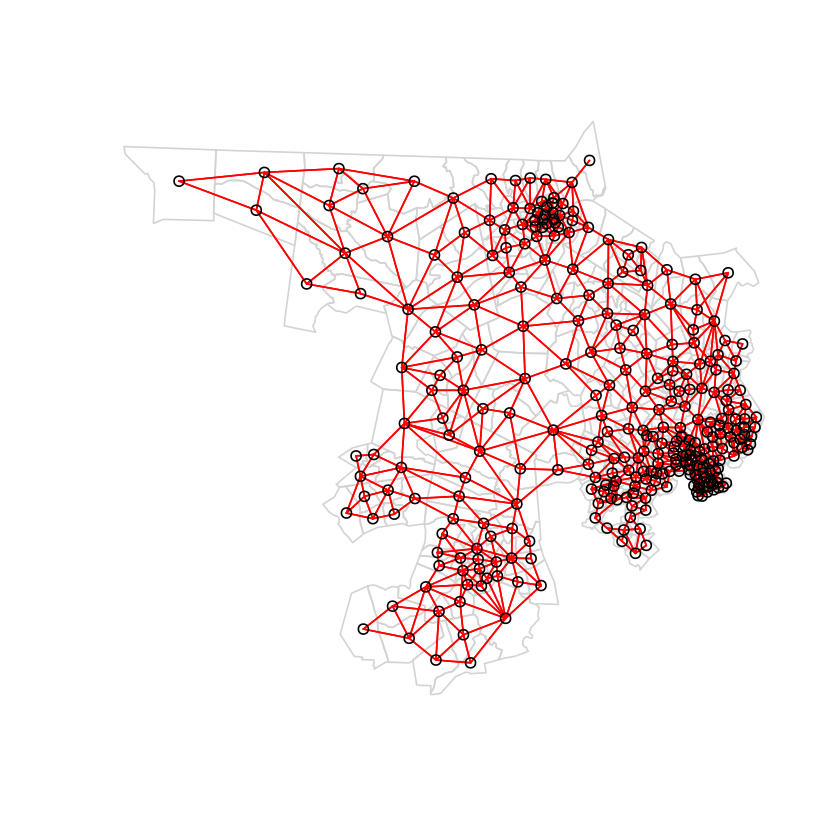

In [96]:
plot(spatial.areas, border = 'lightgrey')
plot(neighbours, coordinates(spatial.areas), add=TRUE, col='red')

In [35]:
# Calculate the Rook's case neighbours
neighbours2 <- poly2nb(OA.Census, queen = FALSE)
neighbours2

Neighbour list object:
Number of regions: 749 
Number of nonzero links: 4176 
Percentage nonzero weights: 0.7443837 
Average number of links: 5.575434 

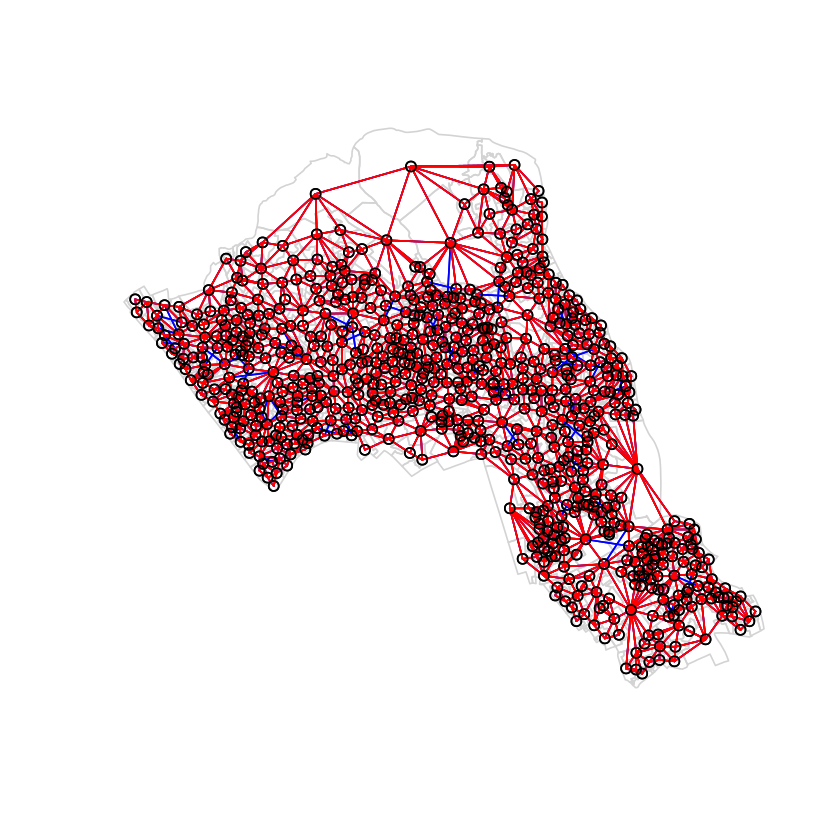

In [36]:
# compares different types of neighbours
plot(OA.Census, border = 'lightgrey')
plot(neighbours, coordinates(OA.Census), add=TRUE, col='blue')
plot(neighbours2, coordinates(OA.Census), add=TRUE, col='red')